# Modelos para variable target binaria

## Imports y data load

In [ ]:
# Standard library
import os
from datetime import datetime
from imblearn.pipeline import Pipeline
from pathlib import Path
import sys

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from scipy.stats import uniform, randint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, make_scorer, 
    precision_score, recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Add parent directory to path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Custom imports
from scripts.results_analyzer import ResultsAnalyzer

In [3]:
data_path = '../data/base_procesada_binaria.csv'

#Constants

TARGET = 'target_binaria'

In [4]:
df_int_binario = pd.read_csv(data_path)
df_int_binario.head()

,Estudios_máximos_antes_de_la_inscripción,estado_civil,sexo,desplazado,Asistencia_diurna/nocturna,Cualificación_promedio_de_estudios_previos,Puntaje_en_examen_de_ingreso,Necesidades_educativas_especiales,Tiene_deuda,Pago_de_matrícula_al_día,...,Carrera_Gestión,Carrera_Ingeniería Informática,Carrera_Periodismo y Comunicación,Carrera_Psicología,Carrera_Publicidad y Marketing,Carrera_Química,Carrera_Sociología,Carrera_Turismo,Carrera_Veterinaria,target_binaria
0,3,1,0,0,1,66,65,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,3,1,0,1,1,69,66,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,1,69,63,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,1,1,68,68,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,3,1,1,1,1,68,70,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [5]:
# Separar features y target
X = df_int_binario.drop(TARGET, axis=1)
y = df_int_binario[TARGET]

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Models

### Regresión logística

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularización
    'classifier__penalty': ['l2'],  # l1 solo con liblinear/saga
    'classifier__class_weight': [None, 'balanced'] 
}

# Crear GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)


for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
classifier__C: 1
classifier__class_weight: None
classifier__penalty: l2
classifier__solver: saga

Mejor F1-score en validación cruzada: 0.8895



RESULTADOS EN TEST SET - LOGISTIC REGRESSION
Accuracy:  0.8574
Precision: 0.8633
Recall:    0.9151
F1-Score:  0.8885
ROC-AUC:   0.9200

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4365
           1       0.86      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



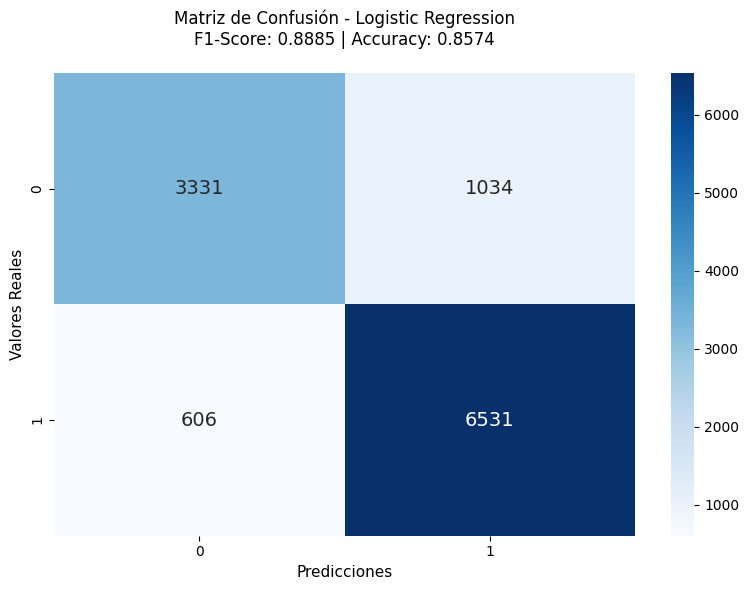

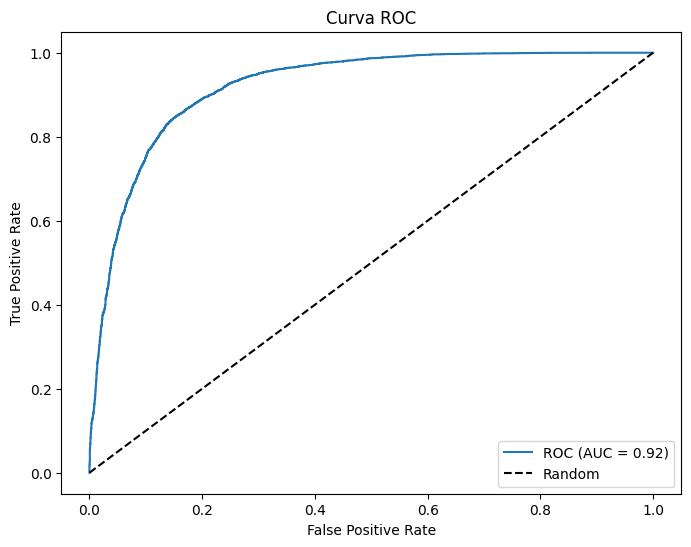

In [7]:
analyzer = ResultsAnalyzer()
results_df = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression")


In [8]:
results_df.head()

,Modelo,Hiperparametros,Accuracy,F1_Score,Precision,Recall,ROC_AUC,CV_F1_Mean,CV_F1_Std,Fecha
0,Logistic Regression,"{'classifier__C': 1, 'classifier__class_weight...",0.8574,0.8885,0.8633,0.9151,0.92,0.8895,0.0022,2025-10-14 20:17:24


Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


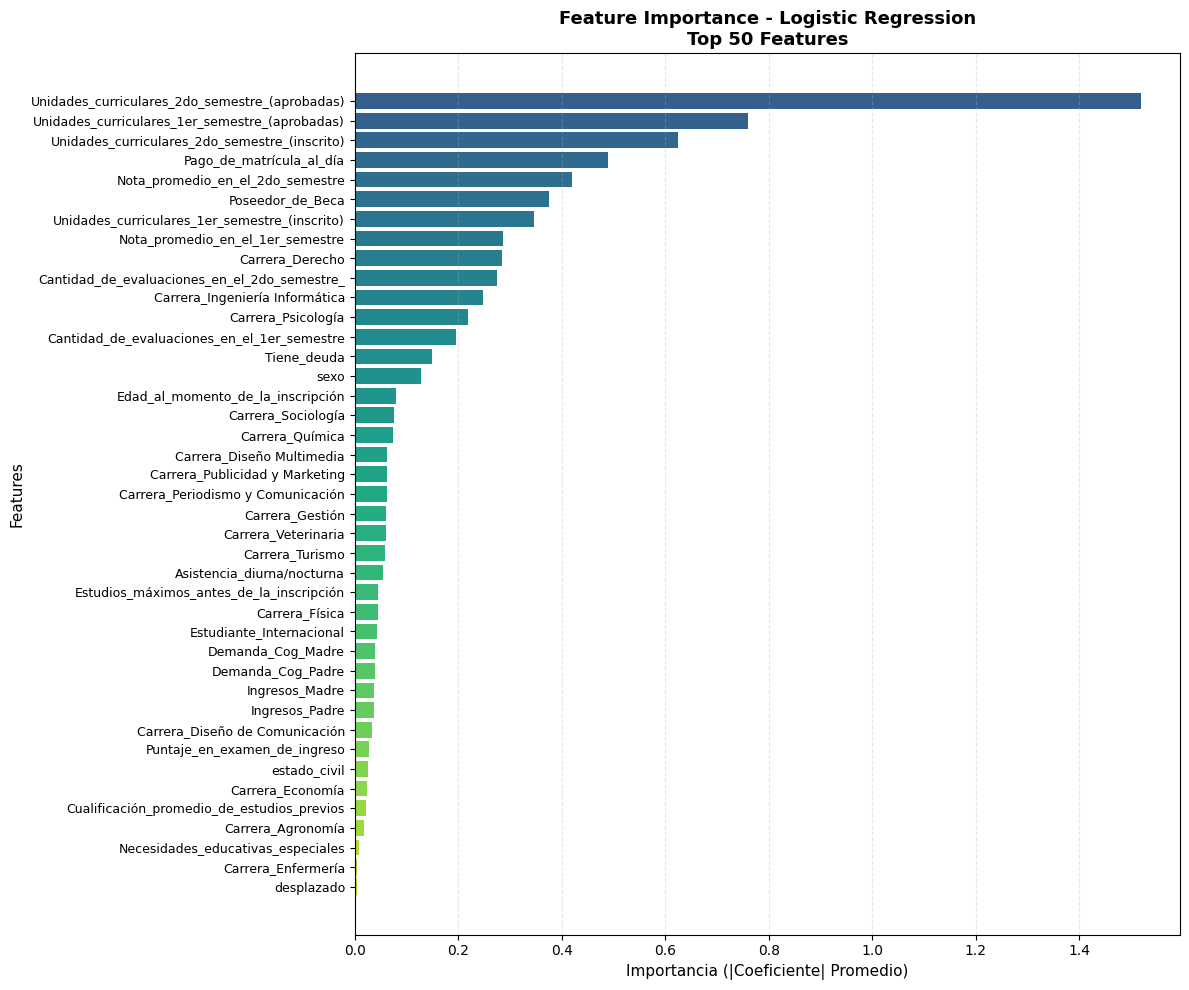


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    1.518340
Unidades_curriculares_1er_semestre_(aprobadas)    0.759649
 Unidades_curriculares_2do_semestre_(inscrito)    0.624119
                      Pago_de_matrícula_al_día    0.488529
              Nota_promedio_en_el_2do_semestre    0.419529
                              Poseedor_de_Beca    0.375895
 Unidades_curriculares_1er_semestre_(inscrito)    0.345347
              Nota_promedio_en_el_1er_semestre    0.286576
                               Carrera_Derecho    0.283575
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.274568
                Carrera_Ingeniería Informática    0.247043
                            Carrera_Psicología    0.219000
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.195908
                                   Tiene_deuda    0.149563
                                          sexo    0.127781
             Edad_al_momento_de_la_ins

In [9]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10)
)

### Logistic Regression con SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 50],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced'] 
}

#GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)


print("\nMejores parámetros:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejores parámetros:
classifier__C: 0.1
classifier__class_weight: None
classifier__penalty: l2
classifier__solver: saga

Mejor F1-score en validación cruzada: 0.8763



RESULTADOS EN TEST SET - LOGISTIC REGRESSION CON SMOTE
Accuracy:  0.8570
Precision: 0.8697
Recall:    0.9051
F1-Score:  0.8871
ROC-AUC:   0.9189

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      4365
           1       0.87      0.91      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



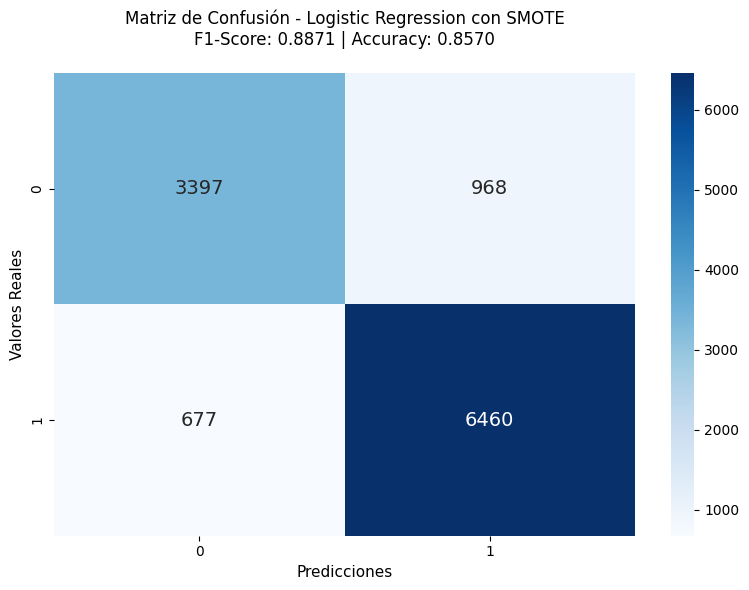

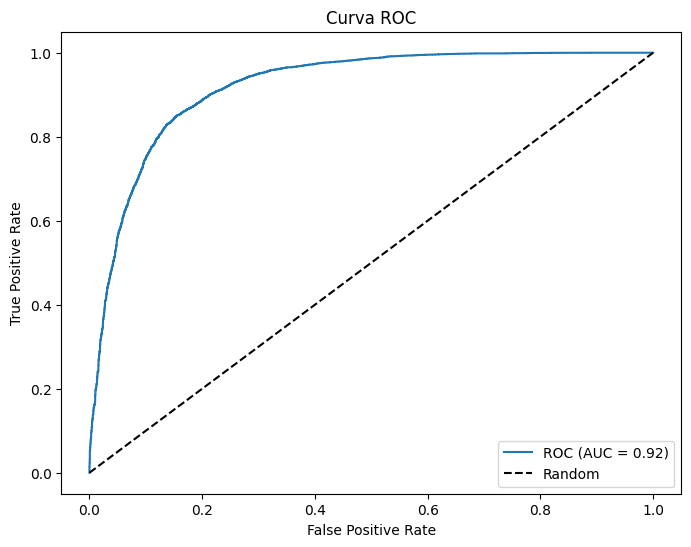

In [11]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression con SMOTE")

In [12]:
results_df = pd.concat([results_df, results], ignore_index=True)

Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


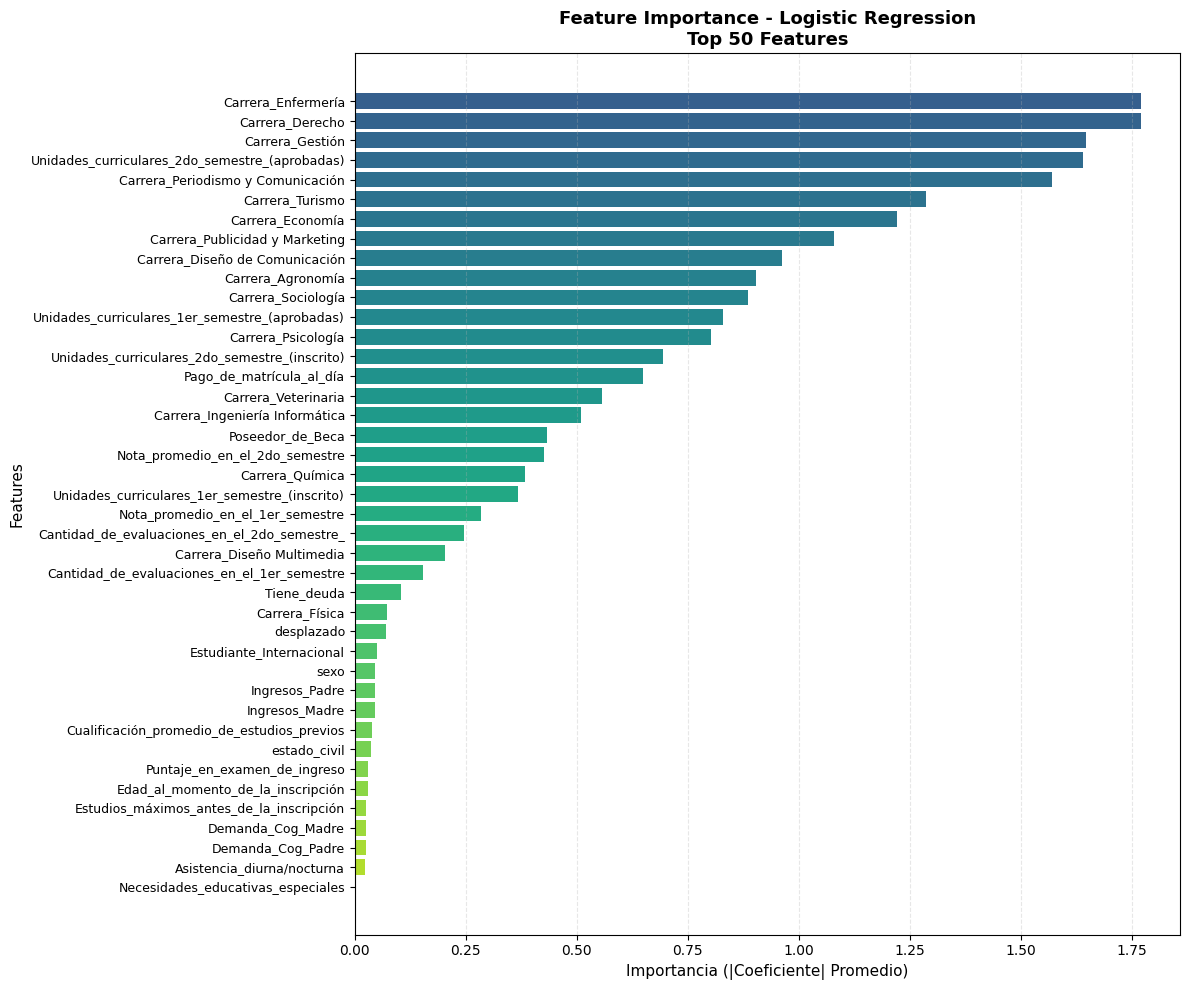


Top 41 Features:
                                       feature  importance
                            Carrera_Enfermería    1.770299
                               Carrera_Derecho    1.770166
                               Carrera_Gestión    1.647098
Unidades_curriculares_2do_semestre_(aprobadas)    1.640889
             Carrera_Periodismo y Comunicación    1.571616
                               Carrera_Turismo    1.287770
                              Carrera_Economía    1.222384
                Carrera_Publicidad y Marketing    1.079125
                Carrera_Diseño de Comunicación    0.962693
                             Carrera_Agronomía    0.904771
                            Carrera_Sociología    0.885793
Unidades_curriculares_1er_semestre_(aprobadas)    0.829558
                            Carrera_Psicología    0.802485
 Unidades_curriculares_2do_semestre_(inscrito)    0.694218
                      Pago_de_matrícula_al_día    0.648945
                           Carrera_Vet

In [13]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### Máquina de vectores de soporte (SVM) 

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True))
])

param_grid = {
    'classifier__C': [0.1, 1, 10], 
    'classifier__kernel': ['linear', 'rbf'],  
    'classifier__gamma': ['scale', 'auto'],  
    'classifier__class_weight': [None, 'balanced']  
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred_svm = best_model.predict(X_test)
y_pred_proba_svm = best_model.predict_proba(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred = y_pred_svm, y_pred_proba = y_pred_proba_svm,
                          nombre_modelo="SVM")

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.head()

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## KNN

In [ ]:
k_values = range(3, 21) 


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'k': k_values,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Probando diferentes valores de k:

k     Accuracy     F1-Score  
------------------------------
1     76.96        0.8174    
2     75.83        0.7895    
3     80.07        0.8453    
4     80.47        0.8410    
5     81.46        0.8568    
6     81.66        0.8540    
7     82.13        0.8624    
8     81.94        0.8576    
9     82.18        0.8629    
10    82.50        0.8625    
11    82.32        0.8641    
12    82.79        0.8655    
13    82.56        0.8660    
14    82.74        0.8655    
15    82.55        0.8661    
16    82.79        0.8663    
17    82.63        0.8668    
18    82.77        0.8664    
19    82.69        0.8673    
20    82.73        0.8664    

Mejor k: 12
Accuracy: 82.79%
F1-Score: 0.8655


In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="KNN")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.head()

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### Árboles de Decisión 


In [ ]:
# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parámetros para GridSearch (opcional)
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)


Accuracy Random Forest: 0.8583


In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Random Forest")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.head()

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Boosting

In [ ]:
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.1,
    random_state=42,
    verbose=-1 ))
])

param_grid = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 15),
}

grid_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting LightGBM ")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.head()

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Optuna para RF

In [ ]:
def objective(trial):
    # Definimos el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Definir el modelo
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar con los datos escalados sin SMOTE
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    acc = accuracy_score(y_test, y_pred)
    return acc

# Crear el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Mostrar los mejores parámetros y el mejor score
print("Mejores hiperparámetros:", study.best_params)
print("Mejor accuracy:", study.best_value)

In [ ]:
# Extraer los valores de accuracy de cada trial
accuracies = [t.value for t in study.trials]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("Evolución de accuracy en Random Forest")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## VOTING

In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Pipeline permite encadenar múltiples pasos de procesamiento o modelos en un solo objeto.
#Con esta función le pido crear cada versión con y sin SMOTE de Regresión, SVM y RF.
#Yo voy a hacer que se vote entre todas las combinaciones posibles pero se podría hacer una votación entre modelos con smote y una votación entre modelos sin smote.

pipe_lr = Pipeline([('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000))])
pipe_lr_smote = Pipeline([('smote', SMOTE(random_state=42)),('lr', LogisticRegression(random_state=42, max_iter=10000))])

pipe_svm = Pipeline([('svm', SVC(probability=True, random_state=42, kernel='linear', C=1))])

pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced',))])
pipe_rf_smote = Pipeline([('smote', SMOTE(random_state=42)),('rf', RandomForestClassifier(random_state=42, n_estimators=500, max_depth=6))])


voting_clf = VotingClassifier(
    estimators=[
        ('lr', pipe_lr),            
        ('lr_smote', pipe_lr_smote),
        ('svm', pipe_svm),
        ('rf', pipe_rf),
        ('rf_smote', pipe_rf_smote)], voting='hard')    #SOFT PARA PREDICCIÓN DE PROBA. HARD PARA PREDICCIÓN DE CLASE.


#voting concatena la información de todas las salidas para predecir.
voting_clf.fit(X_train_scaled, y_train)

,estimators,"[('lr', ...), ('lr_smote', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [ ]:
print(f"Accuracy training : {voting_clf.score(X_train_scaled, y_train):.3f}")
print(f"Accuracy test: {voting_clf.score(X_test_scaled, y_test):.3f}")

Accuracy training : 0.858
Accuracy test: 0.854


VOTING CLASSIFIER - RESULTADO FINAL
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4365
           1       0.89      0.88      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.85      0.85     11502
weighted avg       0.85      0.85      0.85     11502



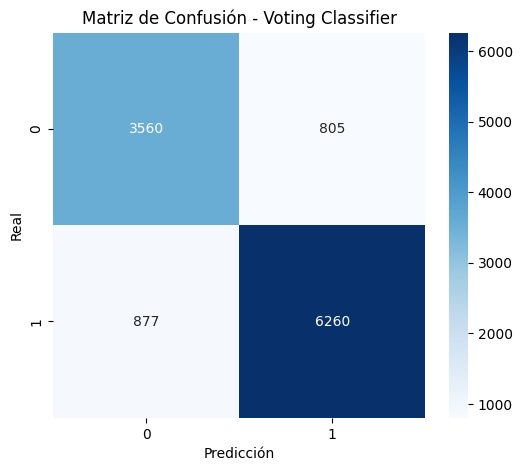

In [ ]:
# Predicciones del voting classifier
y_pred_voting = voting_clf.predict(X_test_scaled)

print("VOTING CLASSIFIER - RESULTADO FINAL")
print("="*60)
print(classification_report(y_test, y_pred_voting))

# Matriz de confusión
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()